GRU and LSTM are both types of recurrent neural networks (RNNs) used for sequential data tasks. They address the vanishing gradient problem of traditional RNNs, which makes them more effective at capturing long-term dependencies in sequence data.

LSTM (Long Short-Term Memory): It is an RNN architecture that uses gating mechanisms to control and manage the information flow in the network. The gates of LSTM are:


*   Forget gate: determines what information to discard from the cell state.
*   Input gate: decides what new information to store in the cell state.
*  Output gate: decides what information to output based on input and the current cell state.


LSTM maintains a separate cell state which can keep information in memory for long periods of time, making it particularly good at understanding context in sentences and documents.


GRU (Gated Recurrent Unit): GRU is a variation of LSTM designed to be more computationally efficient. Unlike LSTM, GRU has two gates:

*   Update gate: similar to the forget and input gate of an LSTM. It decides what information to throw away and what new information to add.
*   Reset gate: used to decide how much past information to forget.




In [1]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 8.4 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import unidecode
import string
import random
import time
import math
import os
import argparse

import matplotlib.pyplot as plt

from tqdm import tqdm

In [ ]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename): # reads a file and returns its content as a string along with its length
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string): # creates a tensor from a string where each character is replaced by its index in the defined dictionary
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

generate()
 function uses an RNN (decoder) to generate a sequence of characters, starting from a given prime string. It warms up the RNN with the prime string, and then generates new characters one by one, feeding each new character back into the RNN to generate the next.

hidden = decoder.init_hidden(1): This line initializes the hidden state of the decoder (a recurrent neural network). The parameter 1 indicates that the batch size is 1.

prime_input = Variable(char_tensor(prime_str).unsqueeze(0)): Here, the function converts the initial string (prime_str) into a tensor that can be used as input to the RNN. This tensor is then unsqueezed to add an extra dimension for batch size, which is required by the RNN.

The if cuda: block moves the hidden state and input tensors to the GPU if the cuda flag is set to True.

predicted = prime_str: The predicted output string is initialized with the prime string.

The first for loop iterates over the prime string (except the last character) and uses it to "warm up" the RNN, i.e., to establish a certain hidden state before starting the actual prediction.

inp = prime_input[:,-1]: The variable inp is initialized as the last character of the prime input. This will be the first input to the prediction phase of the RNN.

The second for loop generates predict_len number of characters. For each character:

The RNN produces an output and an updated hidden state given the current input and hidden state.

The output is transformed into a probability distribution using the softmax function (through .div(temperature).exp()) and then a character index is sampled from this distribution (torch.multinomial(output_dist, 1)[0]).

The sampled character index is then converted back into a character (predicted_char = all_characters[top_i]), which is added to the predicted string.

The input to the next time step of the RNN is then set to this new character.

return predicted: After the loop, the function returns the generated string.

In [ ]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

Class CharRNN defines the architecture of the model which is composed of an embedding layer, a recurrent layer (GRU or LSTM), and a linear output layer. The model takes a batch of sequences and the hidden states as inputs and returns the output and the new hidden states.

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

Function random_training_set(chunk_len, batch_size) creates random sequences from the input file and their targets (the same sequences shifted by one character).

In [ ]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    if cuda:
        inp = inp.cuda()
        target = target.cuda()
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    if cuda:
        hidden = hidden.cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

def save():
    save_filename = os.path.splitext(os.path.basename(filename))[0] + '.pt'
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

In [ ]:
# define args
filename = "/content/shakespeare.txt"
n_epochs = 2000
model = "gru"
print_every = 100
hidden_size = 100
n_layers = 2
learning_rate = 0.01
chunk_len = 200
batch_size = 100
shuffle = True
cuda = False


file, file_len = read_file(filename)

# Initialize models and start training
decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers,
)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Training for 2000 epochs...


  5%|▌         | 100/2000 [01:35<28:29,  1.11it/s]

 35s (100 5%) 1.7598]
What not for yecpatie it dood heart
Well owe joy condo of his is a hildined?

PETRUCHIO:
O brother bee 



 10%|█         | 200/2000 [03:06<30:55,  1.03s/it]

 6s (200 10%) 1.5577]
What shall seeds
For my near better the heard, but not be:
What why, then shall fure the criefter?

GR 



 15%|█▌        | 300/2000 [04:37<29:36,  1.05s/it]

 37s (300 15%) 1.4868]
Where we great sir!

TyGRS:
Or besop of York from your lords, lords, and beseech,
As the evers by the  



 20%|██        | 400/2000 [06:07<26:27,  1.01it/s]

 6s (400 20%) 1.4755]
What's upon his sighs of so;
And have my fangering in thee you there country:
Though a contriciment.
W 



 25%|██▌       | 500/2000 [07:36<23:50,  1.05it/s]

 36s (500 25%) 1.4162]
What harm Menour hath good from him.

Third Murders, show she,
To with cause thou lost the dawn mea.

 



 30%|███       | 600/2000 [09:06<21:56,  1.06it/s]

 6s (600 30%) 1.4237]
Where a tower, all most
It but with the distreford?

First Servition:
My heart, for matters, what brot 



 35%|███▌      | 700/2000 [10:35<20:01,  1.08it/s]

 35s (700 35%) 1.3828]
Where all this holy fellow.

ANGELO:
They shall to apt thyself off with me;
I think, it worthy member  



 40%|████      | 800/2000 [12:05<18:25,  1.09it/s]

 5s (800 40%) 1.3934]
Where was, in your coron.
See the devileds, and lose to my well, appear that you since a dear
maintaim 



 45%|████▌     | 900/2000 [13:34<16:36,  1.10it/s]

 34s (900 45%) 1.3909]
Which man for the man artiest;
For he were her better before to his man
The last here to all the dishe 



 50%|█████     | 1000/2000 [15:04<14:56,  1.12it/s]

 4s (1000 50%) 1.3925]
What's my fairer, when cause for the earth:
And not be shall forguage shall make down the
man: seems,  



 55%|█████▌    | 1100/2000 [16:34<13:25,  1.12it/s]

 34s (1100 55%) 1.3620]
Why do come that he all the sorrow.

KING LEWIS XI:
Be a stand--
If you must come by him, take done,
B 



 60%|██████    | 1200/2000 [18:03<11:40,  1.14it/s]

 3s (1200 60%) 1.3558]
Which I say, be stabs.

GREGORTE:
Now, will, what news in sits in the blood:
My stirrills done of past 



 65%|██████▌   | 1300/2000 [19:33<10:07,  1.15it/s]

 33s (1300 65%) 1.3625]
Whit you will cut a grace thus: where I pray
the marring blood and the son from a lesser.

ARCHBISHOP  



 70%|███████   | 1400/2000 [21:03<08:48,  1.14it/s]

 3s (1400 70%) 1.3772]
What fears this with my hasten,
Until have talk in hand, and so plain thee
his meet the husprince and  



 75%|███████▌  | 1500/2000 [22:34<07:07,  1.17it/s]

 34s (1500 75%) 1.3414]
What is he pays to love the were's prison
My lert warlive and
aboar. Can not, and foring suffer's righ 



 80%|████████  | 1600/2000 [24:04<05:42,  1.17it/s]

 4s (1600 80%) 1.3601]
Who ever have day:
The foes is at yours. May on his name have men's
That I sayorreve and not away.

Fi 



 85%|████████▌ | 1700/2000 [25:34<04:15,  1.17it/s]

 34s (1700 85%) 1.3366]
Which
have I live be golden out me: I cannot
A wind, and hang of my horse enemies,
With like a monious 



 90%|█████████ | 1800/2000 [27:04<02:49,  1.18it/s]

 4s (1800 90%) 1.3184]
Who are Alackly of worse to be honour;
But instant hour with me: whose face of Buckingham.

WARWICK:
I 



 95%|█████████▌| 1900/2000 [28:33<01:26,  1.16it/s]

 33s (1900 95%) 1.3461]
What, what he say my father living was;
But she wishal she shall let the discovered for
time still, th 



100%|██████████| 2000/2000 [30:03<00:00,  1.11it/s]

 3s (2000 100%) 1.3523]
What may for their grave to take the princely of the
entisk him not she a braceles heart
Is a light th 

Saving...
Saved as shakespeare.pt


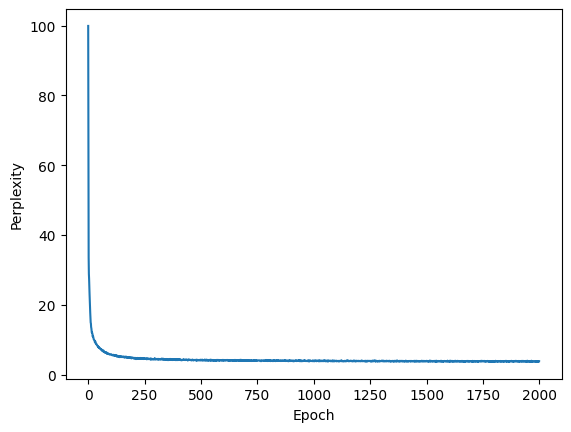

In [ ]:
if cuda:
    decoder.cuda()

start = time.time()
all_losses = []
loss_avg = 0

perplexities = []

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        perplexities.append(math.exp(loss))

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=cuda), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()


plt.plot(perplexities)
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

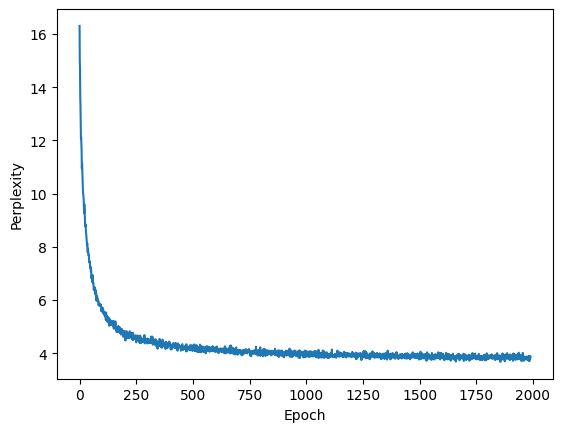

In [ ]:
# if we ignore some of the first epochs we get a much clearer graph
plt.plot(perplexities[10:])
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.show()

The perplexity is a measure of how well the model predicts a sample and it is typically used to compare the performance of different language models. The lower the perplexity, the better the model is at predicting the sample.

PART 2

In [ ]:
import string
import random

def randomString(len):
    s = ""
    for i in range(len):
        s = s + random.choice(string.printable)
    return s

In [ ]:
decoder = torch.load("shakespeare.pt")

for i in range(5):
    prime_string = randomString(5)
    print("======Prime string:",prime_string,"======")
    print(generate(decoder, prime_str=prime_string))

======Prime string: ZGRt: ======
ZGRt:
My lord, her poor England, should but the king
The warlikes of mine hopeful heavy sovereign,
Nor wi
======Prime string: i?F]Z ======
i?F]ZO:
O, it day, fie, I have well.

MARCIUS:
He hath been threadly deserved natures, upon she his persu
======Prime string: XeNnI ======
XeNnI statier his son, I shall bear the rest
the king of like of ground to the socked got or funiut.

KIN
======Prime string: cQzCc ======
cQzCcance good needle brother,
And you must find a love to the bosoms' love,
To seem that sound from hims
======Prime string: Le8Dd ======
Le8Ddlass'd his plarers: a king, deputy'd,
The horse or his son son pressish trougherent.

DUKE VINCENTIO


PART 3

In [ ]:
prime_string = "The"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: The
The heart of hands, if he had now spy to worship
You say I am such undone to my dreament.

BUCKINGHAM:



In [ ]:
prime_string = "What is"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: What is
What is the debt home, our son, wherein in the revounting sorror
Montuned yet to our house, the thought, or


In [ ]:
prime_string = "Shall I give"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: Shall I give
Shall I give him, if what they maid their state,
Which waters of the hands of his word and meet
Myrruly that thi


In [ ]:
prime_string = "X087hNYB BHN BYFVuhsdbs"
print("Prime string:",prime_string)
print(generate(decoder, prime_str=prime_string))

Prime string: X087hNYB BHN BYFVuhsdbs
X087hNYB BHN BYFVuhsdbselves:
His comingary, whose my lord, myself
And stand in me, whose breath and desired,
And there's n


**What are Language Models? Where and how are Language Models used?**

Language Models are a type of models in Natural Language Processing (NLP) that are trained to predict the next word/character in a sequence. Language models learn the probability distribution of a sequence of words, effectively learning the context and semantics of a language. They are widely used in applications like machine translation, speech recognition, text generation, autocorrect, autocomplete, and many others.

**How can you use a trained Char-RNN model as a Character Level Language Model?**

A trained Char-RNN model can be used as a Character Level Language Model by feeding it a sequence of characters (a "primer" or "seed" string) and having it predict the next character. You can then take that predicted character, add it to your input sequence, and ask the model to predict the next character again. Repeating this process allows you to generate new text character by character.

**How can you train a Word Level Language Model?**

Training a Word Level Language Model involves the same principles as training a character level model, but with words as the discrete units of meaning instead of characters. The text corpus is tokenized into words, and the model is trained to predict the next word given a sequence of previous words. The word sequences are often embedded into a higher dimensional space (using techniques like Word2Vec or GloVe) before being fed into the model.

**Formally describe the inference model that an RNN trained to predict the next word represents?**

An RNN used in this way is modeling the conditional probability of the next word given all the previous words.

For instance, let's consider a simplified example. Given the three words "I like apples", an RNN language model might learn to associate high probability with the word "apples" following "I like", because in its training data, "apples" often follow "I like". This is a form of conditional probability - the probability of a certain word, given the previous words.

Formally, this can be represented as P(word_n | word_1, word_2, ..., word_n-1) - the probability of the nth word given all the words before it.

Example: Let's assume we have a sentence "I enjoy playing football". Here, we're trying to predict each word based on the words that come before it.

P("I") : The probability of the first word "I" occurring at the start of a sentence.

P("enjoy" | "I") : The probability of the word "enjoy" occurring given that the preceding word is "I". This is saying, when we have seen the word "I", what's the likelihood the next word is "enjoy"?

P("playing" | "I", "enjoy") : The probability of the word "playing" occurring given that the preceding words are "I enjoy". This is saying, when we have seen the words "I enjoy", what's the likelihood the next word is "playing"?

P("football" | "I", "enjoy", "playing") : The probability of the word "football" occurring given that the preceding words are "I enjoy playing". This is saying, when we have seen the words "I enjoy playing", what's the likelihood the next word is "football"?

 **How will you generate the "probability of existence" of an input sequence of words, given a trained
RNN Language Model?**

"Probability of existence" in this context refers to the joint probability of a whole sequence of words as predicted by the model. For a given sequence of words, this would be the product of the probabilities of each word given the previous words.

As a simple example, let's say we have a trained RNN and we want to find the "probability of existence" for the phrase "I like apples". The model would find the probability of "I" appearing at the start (let's say it's 0.05), then the probability of "like" given "I" (let's say it's 0.4), and then the probability of "apples" given "I like" (let's say it's 0.2). To find the joint probability of the whole phrase, you would multiply those probabilities together: 0.05 * 0.4 * 0.2 = 0.004, so the "probability of existence" of the phrase "I like apples" would be 0.004 according to this model.